In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba 
from numba import prange
from joint_QR import *

In [2]:
from typing import Union

# Generate some fake data

In [3]:
np.random.seed(0)

In [4]:
x_vals = np.arange(-0.99,1, 0.01)
y_vals_true = 0 + 0.5*x_vals + np.random.normal(0,0.5,len(x_vals))

In [5]:
len(y_vals_true)

199

## First Plot: Single sample for multiple tau

In [6]:
# Example X_vals and tau_vals
tau_vals = np.arange(0,1,0.05)[1:]



Text(0, 0.5, 'Y')

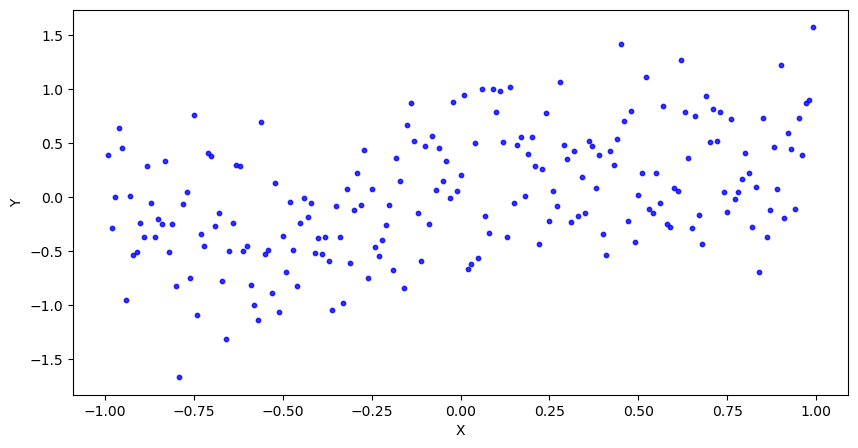

In [7]:
fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(x_vals, y_vals_true, s=10, color='blue', alpha=0.8)
    
ax.set_xlabel('X')
ax.set_ylabel('Y')

# MCMC Sampling

- Block (Metropolis in Gibbs):
- Block 1: Eta Function components, GP, lambda and rho
- Block 2: Remaining, mu, gamma, sigma1 and sigma2

In [8]:
tau_grid_expanded = np.arange(0,1.01,0.01)
tau_grid = np.arange(0.01,1.0,0.01)
knot_points_t = np.arange(0.1,1,0.1)
m = len(knot_points_t)  # no knots

# Calc covariance matrix 
knot_sub_ids = np.array(m*[0] + m*[1]).reshape(-1,1)
knot_points_t = np.concatenate([knot_points_t,
                            knot_points_t]).reshape(-1,1)

knot_points = np.hstack([knot_sub_ids, knot_points_t])

tau_input_test_0 = np.vstack([np.zeros(len(tau_grid)), tau_grid]).T
tau_input_test_1 = np.vstack([np.ones(len(tau_grid)), tau_grid]).T
tau_input = np.vstack([tau_input_test_0, tau_input_test_1])

tau_input_test_0_expanded = np.vstack([np.zeros(len(tau_grid_expanded)),
                                       tau_grid_expanded]).T
tau_input_test_1_expanded= np.vstack([np.ones(len(tau_grid_expanded)),
                                       tau_grid_expanded]).T

tau_input_expanded = np.vstack([tau_input_test_0_expanded,
                                tau_input_test_1_expanded])

In [9]:
kappa_current = 0.5
rho_current = 0.5
lambd_current = 0.5

sigma_1_current = 0.5
sigma_2_current = 0.5
mu_current = 0.5
gamma_current = 0.5

In [10]:
#### W samples
# calc covariance matrix
cov_mat_knots_current = covariance_mat_single_var(knot_points,
                             kappa=kappa_current,
                             rho=rho_current,
                             lambd=lambd_current)

w_knot_points_current = np.random.multivariate_normal(np.zeros(m*2),
                                             cov_mat_knots_current)


# Generate sample of GP approx
w_approx_current = calc_knot_approx_v2(tau_input_expanded,
                                   np.arange(0.1,1,0.1),
                                   cov_mat_knots_current,
                                   w_knot_points_current,
                                   kappa_current,
                                   rho_current,
                                   lambd_current)


In [11]:
y_vals_true = y_vals_true
x_vals = x_vals
w_samples_1=w_approx_current[0:101]
w_samples_2=w_approx_current[101:-1]
sigma_1=sigma_1_current
sigma_2=sigma_2_current
tau_grid_expanded=tau_grid_expanded
tau_grid=tau_grid
mu=mu_current
gamma=gamma_current
base_quantile_mean=0.0
base_quantile_sd=1.0
base_quantile_v=1
base_quantile_dist='norm'

In [13]:
log_lik = []
for i in range(1,len(y_vals_true)):

    y_i = y_vals_true[i]
    x_i = x_vals[i]

    ll_i = grid_search_deriv_approx_vector(y_i=y_i,
                          x_i=x_i,
                          w_samples_1=w_samples_1,
                          w_samples_2=w_samples_2,
                          sigma_1=sigma_1,
                          sigma_2=sigma_2,
                          tau_grid=tau_grid,
                          tau_grid_expanded=tau_grid_expanded,
                          mu=mu,
                          gamma=gamma,
                          base_quantile_mean=base_quantile_mean,
                          base_quantile_sd=base_quantile_sd,
                          base_quantile_v=base_quantile_v,
                          base_quantile_dist=base_quantile_dist)

    log_lik.append(ll_i)

#log_lik = -1 * log_lik

In [14]:
log_lik

[1.587340011260849,
 1.233257165856265,
 6.27565077966826,
 1.7115414400443436,
 8.834731047720902,
 1.2378163361516106,
 2.791938006932024,
 2.611724761222851,
 1.5858826015310608,
 1.950766550310527,
 1.317463732586226,
 1.296682087637187,
 2.0275565499903982,
 1.5177073632449343,
 1.6651635904477338,
 1.3328359721040228,
 3.00322566855037,
 1.6645743936954434,
 8.819080506338175,
 25.616217916649475,
 1.3537392014216223,
 1.2566175076072053,
 6.629691061620945,
 2.6960687248766524,
 25.602239536649883,
 2.111149430906443,
 2.783920146591365,
 1.3683220841086186,
 1.334080492639932,
 1.945607921206736,
 1.582005371788914,
 8.80454786076851,
 25.57987412865059,
 3.5864853654749362,
 1.9443182639307925,
 2.4674578369126157,
 2.46752543122443,
 3.584420018897613,
 3.2559059806397856,
 13.858406339080487,
 25.557508720651345,
 25.5547130446514,
 1.8314015991348838,
 4.570675623755582,
 4.003280580524698,
 13.848722173921157,
 1.2827944001349805,
 25.537938988651952,
 2.7751005002166402,


In [21]:
y_i = y_vals_true[i]
x_i = x_vals[i]

In [22]:
    Q_y_i_vals = Q_joint_quantile_function_vector(tau_input=tau_grid,
                                              x_vals=x_i,
                                              w_samples_1=w_samples_1,
                                              w_samples_2=w_samples_2,
                                              sigma_1=sigma_1,
                                              sigma_2=sigma_2,
                                              tau_grid=tau_grid_expanded,
                                              mu=mu,
                                              gamma=gamma,
                                              base_quantile_mean=base_quantile_mean,
                                              base_quantile_sd=base_quantile_sd,
                                              base_quantile_v=base_quantile_v,
                                              base_quantile_dist=base_quantile_dist)

ValueError: cannot assign slice from input of different size

In [25]:


tau_input = tau_grid
tau_input_expanded = tau_grid_expanded
c_vals_i = np.exp(w_samples_1)

In [33]:
# Calc grid distance
trapz_len = tau_grid_expanded[1] - tau_grid_expanded[0]

# Calc normalizing constant
norm_const = calc_grid_trapezoidal(tau_grid_expanded,
                                   c_vals_i,
                                   len(tau_grid_expanded)-1)

# Get position where tau input falls on grid
t_ls = get_interval_vector(tau_input, tau_grid_expanded).astype('int')
t_ls_1 = t_ls-1

"""
if hasattr(tau_input, "__len__"):
    t_ls = t_ls.astype('int')
else:
    t_ls = int(t_ls)

t_ls_1 = t_ls-1
"""

#e_i
#c_samp_repeat = np.repeat(c_vals_i[:,np.newaxis],len(tau_input), axis=1).T
c_samp_repeat = np.repeat(c_vals_i,len(tau_input)).reshape((len(c_vals_i), 
                                                len(tau_input))).T

e_t_l = calc_grid_trapezoidal_vector(tau_grid_expanded, c_vals_i, c_samp_repeat, t_ls) / norm_const

if len(t_ls) == 1:
    if t_ls[0] == 0:
        diff = e_t_l / 2
        #return e_t_l-diff # Specific edge case when tau input is at left boundary 

e_t_l_1 = np.zeros(len(e_t_l)) 
e_t_l_1[1:-1] =  e_t_l[0:len(e_t_l)-2]
#e_t_l_1 = np.concatenate([np.array([0.0]),e_t_l[0:len(e_t_l)-1]])

#e_t_l_1 = calc_grid_trapezoidal_vector(tau_grid_expanded, c_vals_i, c_samp_repeat, t_ls_1) / norm_const

"""
e_tau_hat = (e_t_l*(tau_input - tau_grid[t_ls_1]) + \
            e_t_l_1*(tau_grid[t_ls]-tau_input) - \
            (tau_input-tau_grid[t_ls_1])*(tau_grid[t_ls]-tau_input)*(c_vals_i[t_ls]-c_vals_i[t_ls_1])) / \
            (tau_grid[t_ls] - tau_grid[t_ls_1])
"""
e_tau_hat = (e_t_l*(tau_input - tau_grid_expanded[t_ls_1]) + \
            e_t_l_1*(tau_grid_expanded[t_ls]-tau_input) - \
            (tau_input-tau_grid_expanded[t_ls_1])*(tau_grid_expanded[t_ls]-tau_input)*(e_t_l-e_t_l_1)) / \
            (tau_grid_expanded[t_ls] - tau_grid_expanded[t_ls_1])

In [32]:
e_t_l_1[1:-1].shape

(97,)

In [30]:
e_t_l[1:-1].shape

(97,)

In [246]:
w_approx_current.shape

(202,)

In [132]:
len(w_approx_current)/2

101.0

In [134]:
w1_samples = w_approx_current[0:len(w_approx_current)//2]
w2_samples = w_approx_current[len(w_approx_current)//2:]

In [142]:
np.exp(w1_samples)

array([6.1799804 , 5.80281868, 5.38663535, 4.94858938, 4.50501567,
       4.07029947, 3.65613269, 3.27118026, 2.92111394, 2.60892434,
       2.33540337, 2.09969487, 1.89983296, 1.73321499, 1.59698282,
       1.48830686, 1.40458082, 1.3435423 , 1.30333582, 1.28253365,
       1.28012665, 1.29549366, 1.32835477, 1.37871132, 1.44677397,
       1.53288011, 1.63740273, 1.76065517, 1.90279856, 2.06376189,
       2.24318612, 2.44040365, 2.65446188, 2.8841938 , 3.12833111,
       3.38564688, 3.65510776, 3.93601106, 4.22808179, 4.53150746,
       4.84689427, 5.17513495, 5.51718497, 5.87374946, 6.24488866,
       6.62955634, 7.02509558, 7.42673137, 7.82711942, 8.21603396,
       8.58029761, 8.90406453, 9.16955278, 9.35827184, 9.45270468,
       9.43828879, 9.30542414, 9.05115496, 8.68016672, 8.20483047,
       7.64420596, 7.0221367 , 6.36476964, 5.69794531, 5.04489959,
       4.42460518, 3.85090455, 3.3324069 , 2.8729874 , 2.47266211,
       2.1286134 , 1.83618631, 1.58974167, 1.38331395, 1.21106

In [205]:
w1_samples[0] = 50
c_vals_i = np.exp(w1_samples)


In [240]:
tau_input = tau_grid

# Calc grid distance
trapz_len = tau_grid[1] - tau_grid[0]

# Calc normalizing constant
norm_const = calc_grid_trapezoidal(tau_grid_expanded,
                                   c_vals_i,
                                   len(tau_grid_expanded)-1)

# Get position where tau input falls on grid
t_ls = get_interval_vector(tau_grid,
                           tau_grid_expanded).astype('int')

c_samp_repeat = np.repeat(c_vals_i,len(tau_input)).reshape((len(c_vals_i), 
                                                len(tau_input))).T

e_t_l = calc_grid_trapezoidal_vector(tau_grid,
                                     c_vals_i,
                                     c_samp_repeat, t_ls) / norm_const

t_ls_1 = t_ls-1

e_t_l_1 = calc_grid_trapezoidal_vector(tau_grid, c_vals_i, c_samp_repeat, t_ls_1) / norm_const
e_t_l_1 = np.concatenate([np.array([0]),e_t_l[0:len(e_t_l)-1]])

e_tau_hat = (e_t_l*(tau_input - tau_grid_expanded[t_ls_1]) + \
            e_t_l_1*(tau_grid_expanded[t_ls]-tau_input) - \
            (tau_input-tau_grid_expanded[t_ls_1])*(tau_grid_expanded[t_ls]-tau_input)*(e_t_l-e_t_l_1)) / \
            (tau_grid_expanded[t_ls] - tau_grid_expanded[t_ls_1])

if e_tau_hat[0] == 1:
    print('asd')
    e_tau_hat -= 1e-16

asd


In [242]:
norm.ppf(e_tau_hat,0,1)

array([8.20953615, 8.20953615, 8.20953615, 8.20953615, 8.20953615,
       8.20953615, 8.20953615, 8.20953615, 8.20953615, 8.20953615,
       8.20953615, 8.20953615, 8.20953615, 8.20953615, 8.20953615,
       8.20953615, 8.20953615, 8.20953615, 8.20953615, 8.20953615,
       8.20953615, 8.20953615, 8.20953615, 8.20953615, 8.20953615,
       8.20953615, 8.20953615, 8.20953615, 8.20953615, 8.20953615,
       8.20953615, 8.20953615, 8.20953615, 8.20953615, 8.20953615,
       8.20953615, 8.20953615, 8.20953615, 8.20953615, 8.20953615,
       8.20953615, 8.20953615, 8.20953615, 8.20953615, 8.20953615,
       8.20953615, 8.20953615, 8.20953615, 8.20953615, 8.20953615,
       8.20953615, 8.20953615, 8.20953615, 8.20953615, 8.20953615,
       8.20953615, 8.20953615, 8.20953615, 8.20953615, 8.20953615,
       8.20953615, 8.20953615, 8.20953615, 8.20953615, 8.20953615,
       8.20953615, 8.20953615, 8.20953615, 8.20953615, 8.20953615,
       8.20953615, 8.20953615, 8.20953615, 8.20953615, 8.20953

In [209]:
e_tau_hat

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [196]:
e_t_l_1v2 = np.concatenate([np.array([0]),e_t_l[0:len(e_t_l)-1]])

In [197]:
e_t_l_1v2

array([0.        , 0.01825559, 0.03530253, 0.05104807, 0.06545048,
       0.07851482, 0.09028591, 0.10083955, 0.11027341, 0.11869833,
       0.12623093, 0.13298772, 0.13908094, 0.14461582, 0.15438971,
       0.15879697, 0.15879697, 0.16298369, 0.16701617, 0.17095569,
       0.17485986, 0.17878378, 0.18278117, 0.18690533, 0.19120991,
       0.19574937, 0.20057924, 0.20575612, 0.21738032, 0.22394188,
       0.22394188, 0.23107725, 0.23883919, 0.24727724, 0.25643722,
       0.26636115, 0.27708762, 0.28865256, 0.30109042, 0.3144355 ,
       0.32872334, 0.34399173, 0.36028129, 0.37763519, 0.39609773,
       0.41571172, 0.43651435, 0.45853147, 0.48177045, 0.50621192,
       0.53180084, 0.55843797, 0.58597282, 0.61419964, 0.64285785,
       0.67163795, 0.72815961, 0.75517298, 0.78089699, 0.78089699,
       0.80504272, 0.82738665, 0.84778137, 0.86615871, 0.88252525,
       0.89695188, 0.90955948, 0.92050313, 0.92995694, 0.93810095,
       0.94511091, 0.95115122, 0.95637056, 0.96089996, 0.96485

In [198]:
e_t_l_1

array([0.01883019, 0.01825559, 0.03530253, 0.05104807, 0.06545048,
       0.07851482, 0.09028591, 0.10083955, 0.11027341, 0.11869833,
       0.12623093, 0.13298772, 0.13908094, 0.14968932, 0.15438971,
       0.15438971, 0.15879697, 0.16298369, 0.16701617, 0.17095569,
       0.17485986, 0.17878378, 0.18278117, 0.18690533, 0.19120991,
       0.19574937, 0.20057924, 0.21133733, 0.21738032, 0.21738032,
       0.22394188, 0.23107725, 0.23883919, 0.24727724, 0.25643722,
       0.26636115, 0.27708762, 0.28865256, 0.30109042, 0.3144355 ,
       0.32872334, 0.34399173, 0.36028129, 0.37763519, 0.39609773,
       0.41571172, 0.43651435, 0.45853147, 0.48177045, 0.50621192,
       0.53180084, 0.55843797, 0.58597282, 0.61419964, 0.64285785,
       0.70019368, 0.72815961, 0.75517298, 0.75517298, 0.78089699,
       0.80504272, 0.82738665, 0.84778137, 0.86615871, 0.88252525,
       0.89695188, 0.90955948, 0.92050313, 0.92995694, 0.93810095,
       0.94511091, 0.95115122, 0.95637056, 0.96089996, 0.96485

In [187]:
e_t_l

array([0.01825559, 0.03530253, 0.05104807, 0.06545048, 0.07851482,
       0.09028591, 0.10083955, 0.11027341, 0.11869833, 0.12623093,
       0.13298772, 0.13908094, 0.14461582, 0.15438971, 0.15879697,
       0.15879697, 0.16298369, 0.16701617, 0.17095569, 0.17485986,
       0.17878378, 0.18278117, 0.18690533, 0.19120991, 0.19574937,
       0.20057924, 0.20575612, 0.21738032, 0.22394188, 0.22394188,
       0.23107725, 0.23883919, 0.24727724, 0.25643722, 0.26636115,
       0.27708762, 0.28865256, 0.30109042, 0.3144355 , 0.32872334,
       0.34399173, 0.36028129, 0.37763519, 0.39609773, 0.41571172,
       0.43651435, 0.45853147, 0.48177045, 0.50621192, 0.53180084,
       0.55843797, 0.58597282, 0.61419964, 0.64285785, 0.67163795,
       0.72815961, 0.75517298, 0.78089699, 0.78089699, 0.80504272,
       0.82738665, 0.84778137, 0.86615871, 0.88252525, 0.89695188,
       0.90955948, 0.92050313, 0.92995694, 0.93810095, 0.94511091,
       0.95115122, 0.95637056, 0.96089996, 0.96485246, 0.96832

In [183]:
norm_const

3.2819533646495405

In [184]:
c_vals_i

array([6.1799804 , 5.80281868, 5.38663535, 4.94858938, 4.50501567,
       4.07029947, 3.65613269, 3.27118026, 2.92111394, 2.60892434,
       2.33540337, 2.09969487, 1.89983296, 1.73321499, 1.59698282,
       1.48830686, 1.40458082, 1.3435423 , 1.30333582, 1.28253365,
       1.28012665, 1.29549366, 1.32835477, 1.37871132, 1.44677397,
       1.53288011, 1.63740273, 1.76065517, 1.90279856, 2.06376189,
       2.24318612, 2.44040365, 2.65446188, 2.8841938 , 3.12833111,
       3.38564688, 3.65510776, 3.93601106, 4.22808179, 4.53150746,
       4.84689427, 5.17513495, 5.51718497, 5.87374946, 6.24488866,
       6.62955634, 7.02509558, 7.42673137, 7.82711942, 8.21603396,
       8.58029761, 8.90406453, 9.16955278, 9.35827184, 9.45270468,
       9.43828879, 9.30542414, 9.05115496, 8.68016672, 8.20483047,
       7.64420596, 7.0221367 , 6.36476964, 5.69794531, 5.04489959,
       4.42460518, 3.85090455, 3.3324069 , 2.8729874 , 2.47266211,
       2.1286134 , 1.83618631, 1.58974167, 1.38331395, 1.21106

In [163]:
c_vals_i[-1]

0.1282940692457394

In [174]:
len(tau_grid_expanded)-1

100

In [178]:
((trapz_len)/2) * (c_vals_i[0] +
                   2*c_vals_i[1:-1].sum() +
                   c_vals_i[-1])


3.28195336464954

In [177]:
((trapz_len)/2) * (c_vals_i[0] +
                   2*c_vals_i[1:100].sum() +
                   c_vals_i[100])


3.28195336464954

In [168]:
norm_const

3.2792127781692098

In [141]:
calc_grid_trapezoidal_vector(tau_grid_expanded,
                      np.exp(w1_samples),
                      )

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<class 'slice'>) found for signature:
 
 >>> slice(Literal[int](1), array(float64, 1d, C))
 
There are 2 candidate implementations:
[1m    - Of which 2 did not match due to:
    Type Restricted Function in function 'slice': File: unknown: Line unknown.
      With argument(s): '(int64, array(float64, 1d, C))':[0m
[1m     No match for registered cases:
      * (int64,) -> slice<a:b>
      * (none,) -> slice<a:b>
      * (none, none) -> slice<a:b>
      * (none, int64) -> slice<a:b>
      * (int64, none) -> slice<a:b>
      * (int64, int64) -> slice<a:b>
      * (int64, int64, int64) -> slice<a:b:c>
      * (none, int64, int64) -> slice<a:b:c>
      * (int64, none, int64) -> slice<a:b:c>
      * (int64, int64, none) -> slice<a:b:c>
      * (int64, none, none) -> slice<a:b:c>
      * (none, int64, none) -> slice<a:b:c>
      * (none, none, int64) -> slice<a:b:c>
      * (none, none, none) -> slice<a:b:c>[0m
[0m
[0m[1mDuring: resolving callee type: Function(<class 'slice'>)[0m
[0m[1mDuring: typing of call at /Users/tzehongti/Desktop/Duke /Thesis/QR_repo/joint_QR.py (106)
[0m
[1m
File "joint_QR.py", line 106:[0m
[1mdef calc_grid_trapezoidal(tau_grid: np.ndarray, c_vals:np.ndarray, last_id: int) -> float:    
    <source elided>
    trapz_len = tau_grid[1] - tau_grid[0]
[1m    trapz_sum = (trapz_len/2)*(c_vals[0] + 2*c_vals[1:last_id].sum() + c_vals[last_id])
[0m    [1m^[0m[0m


In [139]:
w1_samples

array([ 1.8213151 ,  1.75834378,  1.68392095,  1.59910256,  1.50519137,
        1.40371658,  1.29640595,  1.18515086,  1.07196503,  0.95893801,
        0.84818463,  0.74179203,  0.64176597,  0.54997806,  0.46811611,
        0.39763914,  0.33973891,  0.29530963,  0.26492699,  0.24883753,
        0.24695902,  0.25889182,  0.28394116,  0.32114924,  0.36933623,
        0.42714839,  0.49311129,  0.565686  ,  0.64332573,  0.72453048,
        0.80789723,  0.89216346,  0.97624195,  1.05924542,  1.14049967,
        1.21954499,  1.29612558,  1.37016779,  1.44174841,  1.51105466,
        1.57833814,  1.64386542,  1.70786776,  1.77049318,  1.83176331,
        1.89153788,  1.94948882,  2.00508584,  2.05759455,  2.10608761,
        2.1494686 ,  2.18650786,  2.21588852,  2.23626064,  2.24630091,
        2.24477469,  2.23059747,  2.20289237,  2.16104074,  2.10472306,
        2.03394797,  1.94906754,  1.85077804,  1.74010564,  1.61837775,
        1.48718105,  1.34830807,  1.20369484,  1.0553524 ,  0.90

# MCMC Sampling Loop with Approximation

Setting priors for 
- W $\sim$ GP Thingy (Just draw from multviariate)?
- $\kappa^2 \sim  IG(3,1/3)$
- $\lambda^2 \sim Ga(5,1/10)$
- $\rho \sim Unif(0,1)$
- $\sigma_1, \sigma_2 \sim Ga(2,2)$
- $\mu \sim N(0,1)$
- $\gamma \sim N(0,1)$

Block metropolis with blocks
- W, $\kappa^2$, $\lambda^2$, $\rho$
-  $\sigma_1, \sigma_2, \mu, \gamma$

In [157]:
from scipy.stats import multivariate_normal, gamma
import time
from scipy.linalg import block_diag

In [329]:
# Set MCMC Parameters
s = time.time()
n_steps = 20000
lol_cnt = 0

# Set adaptive metropolis step sizes
C_1= 0.5
lambda_step_size_1 = 3
alpha_step_size_1 = 0.5
step_sizes_1 = C_1/(np.arange(1,n_steps+10)**alpha_step_size_1)
a_target_1 = 0.4

C_2 = 0.8
lambda_step_size_2 = 3
alpha_step_size_2 = 0.3
step_sizes_2 = C_2/(np.arange(1,n_steps+10)**alpha_step_size_2)
a_target_2 = 0.4

# Set knot points for approx
tau_grid_expanded = np.arange(0,1.01,0.01)
tau_grid = np.arange(0.01,1.0,0.01)
knot_points_t = np.arange(0.1,1,0.1)
m = len(knot_points_t)  # no knots


# Calc covariance matrix 
knot_sub_ids = np.array(m*[0] + m*[1]).reshape(-1,1)
knot_points_t = np.concatenate([knot_points_t,
                            knot_points_t]).reshape(-1,1)

knot_points = np.hstack([knot_sub_ids, knot_points_t])

tau_input_test_0 = np.vstack([np.zeros(len(tau_grid)), tau_grid]).T
tau_input_test_1 = np.vstack([np.ones(len(tau_grid)), tau_grid]).T
tau_input = np.vstack([tau_input_test_0, tau_input_test_1])

tau_input_test_0_expanded = np.vstack([np.zeros(len(tau_grid_expanded)),
                                       tau_grid_expanded]).T
tau_input_test_1_expanded= np.vstack([np.ones(len(tau_grid_expanded)),
                                       tau_grid_expanded]).T

tau_input_expanded = np.vstack([tau_input_test_0_expanded,
                                tau_input_test_1_expanded])



#### Initialize variables

## GP Related hyperparameters
kappa_current = 3
rho_current = 0
lambd_current = 4

## Regression related parametrs
mu_current = 0
gamma_current = 1
sigma_1_current = 1
sigma_2_current = 1


#### W samples
# calc covariance matrix
cov_mat_knots_current = covariance_mat_single_var(knot_points,
                             kappa=kappa_current,
                             rho=rho_current,
                             lambd=lambd_current)

w_knot_points_current = np.random.multivariate_normal(np.zeros(m*2),
                                             cov_mat_knots_current)


# Generate sample of GP approx
w_approx_current = calc_knot_approx_v2(tau_input_expanded,
                                   np.arange(0.1,1,0.1),
                                   cov_mat_knots_current,
                                   w_knot_points_current,
                                   kappa_current,
                                   rho_current,
                                   lambd_current)



# Storage variables
w_approx_store = []
kappa_store = []
lambda_store = []
rho_store = []

sigma_1_store = []
sigma_2_store = []
mu_store = []
gamma_store = []


kappa_accept = 0
lambda_accept = 0
rho_accept= 0 
sigma_accept = 0
mu_accept = 0
gamma_accept = 0

### initialise adaptive metropolis

# Block 1
am_lamb_block1 = 0.5
log_am_lamb_block1 = np.log(am_lamb_block1)
am_cov_block1 = 0.5*block_diag(cov_mat_knots_current, np.eye(2))#np.eye(len(w_knot_points_current)+2)

mu_block1 = np.concatenate([w_knot_points_current,
                               np.array([kappa_current]),
                               np.array([lambd_current])])
                              # np.array([rho_current])])
    
# Block 2
am_lamb_block2 = 0.5
log_am_lamb_block2 = np.log(am_lamb_block2)
am_cov_block2 = np.diag([0.1,0.1,0.5,0.5])
mu_block2 = np.concatenate([np.array([mu_current]),
                               np.array([gamma_current]),
                               np.array([np.log(sigma_1_current),
                                         np.log(sigma_2_current)])])



rho_current = 0.5
checks = []
prop_check1 = []
prop_check2 = []
a_check = []

block_1_accept_cnts = 0
block_2_accept_cnts = 0
blk2_check = []

In [330]:
cov_store_2 = []
mu_block_store_2 =[]
am_params_store_2 = []
a_check2 = []

In [331]:
from scipy.stats import gamma

In [332]:
for mc_i in range(n_steps): 
    
    #print(mc_i)
    
    #### Generate Sample for W, kappa, tau, lamdba
    
    am_lamb_block1 = np.exp(log_am_lamb_block1)
    proposal_vec  = np.random.multivariate_normal(mu_block1,
                                                 am_lamb_block1*am_cov_block1)
    
    w_knot_prop = proposal_vec[0:len(w_knot_points_current)]
    
    kappa_prop = proposal_vec[len(w_knot_points_current)]
    lambd_prop = proposal_vec[len(w_knot_points_current)+1]
    #log_rho_prop = proposal_vec[len(w_knot_points_current)+2]
    
    prop_check1.append(proposal_vec)
    
    rho_prop = 0.5#1/(1+e**log_rho_prop)
    
    cov_mat_knot_prop = covariance_mat_single_var(knot_points,
                             kappa=kappa_prop,
                             rho=rho_prop,
                             lambd=lambd_prop)
    
    # Update w_sample
    w_approx_prop = calc_knot_approx_v2(tau_input_expanded,
                                   np.arange(0.1,1,0.1),
                                   cov_mat_knot_prop,
                                   w_knot_prop,
                                   kappa_prop,
                                   rho_prop,
                                   lambd_prop)

    # Calc likelihood
    ll_prop = eval_ll(y_vals_true,
                      x_vals,
                      w_samples_1=w_approx_prop[0:101],
                      w_samples_2=w_approx_prop[101:],
                      sigma_1=sigma_1_current,
                      sigma_2=sigma_2_current,
                      tau_grid=tau_grid,
                      tau_grid_expanded=tau_grid_expanded,
                      mu=mu_current,
                      gamma=gamma_current,
                      base_quantile_mean=0.0,
                      base_quantile_sd=1.0,
                      base_quantile_v=1,
                      base_quantile_dist='norm')

    ll_curr = eval_ll(y_vals_true,
                      x_vals,
                      w_samples_1=w_approx_current[0:101],
                      w_samples_2=w_approx_current[101:],
                      sigma_1=sigma_1_current,
                      sigma_2=sigma_2_current,
                      tau_grid=tau_grid,
                      tau_grid_expanded=tau_grid_expanded,
                      mu=mu_current,
                      gamma=gamma_current,
                      base_quantile_mean=0.0,
                      base_quantile_sd=1.0,
                      base_quantile_v=1,
                      base_quantile_dist='norm')    

    checks.append((ll_prop, ll_curr))
    # Take metropolis step
    
    log_prior_prop = logpdf_mvn(w_knot_prop,np.zeros(m*2),cov_mat_knot_prop) +\
                     gamma.logpdf(1/kappa_prop**(2),  a=3, scale=1/3) +\
                     gamma.logpdf(lambd_prop**(2),  a=5, scale=1/10) 
    
    
    log_prior_current = logpdf_mvn(w_knot_points_current,np.zeros(m*2),cov_mat_knots_current) +\
                 gamma.logpdf(1/kappa_current**(2),  a=3, scale=1/3) +\
                 gamma.logpdf(lambd_current**(2),  a=5, scale=1/10) 
    
    
    
    """
    log_proposal_prop = multivariate_normal.logpdf(proposal_vec,
                                                  mu_block1,
                                                  am_lamb_block1*am_cov_block1,
                                                  allow_singular=True)
    """
    log_proposal_prop = logpdf_mvn(proposal_vec,
                                   mu_block1,
                                   am_lamb_block1*am_cov_block1)
    
    current_vec = np.concatenate([w_knot_points_current,
                               np.array([kappa_current]),
                               np.array([lambd_current])])
    
    """
    log_proposal_current = multivariate_normal.logpdf(current_vec,
                                                  mu_block1,
                                                  am_lamb_block1*am_cov_block1)
    """
    log_proposal_current = logpdf_mvn(current_vec,
                               mu_block1,
                               am_lamb_block1*am_cov_block1)
    
    
    a = np.exp(min(0,  (ll_prop + log_prior_prop + log_proposal_current) - \
                       (ll_curr + log_prior_current + log_proposal_prop) ))
    
    a_check.append(a)
    #print(a)
    if np.random.uniform(0,1) < a:
        w_knot_points_current = w_knot_prop
        kappa_current = kappa_prop
        lambd_current = lambd_prop
        kappa_current = kappa_prop
        rho_current = rho_prop
        
        block_1_accept_cnts += 1
    else: 
        w_knot_points_current = w_knot_points_current
        kappa_current = kappa_current
        lambd_current = lambd_current
        kappa_current = kappa_current
        rho_current = rho_current
    
    # Update w 
    w_approx_current = calc_knot_approx_v2(tau_input_expanded,
                                   np.arange(0.1,1,0.1),
                                   cov_mat_knots_current,
                                   w_knot_points_current,
                                   kappa_current,
                                   rho_current,
                                   lambd_current)
    
    
    cov_mat_knots_current = covariance_mat_single_var(knot_points,
                             kappa=kappa_current,
                             rho=rho_current,
                             lambd=lambd_current)
    
    # Update AM sampling parameters
    update_block = np.concatenate([w_knot_points_current,
                               np.array([kappa_current]),
                               np.array([lambd_current])])
                              # np.array([np.log(rho_current/(1-rho_current))])])
    

    
    # Adaptive metropolis update for block 1
    log_am_lamb_block1 = log_am_lamb_block1 + step_sizes_1[mc_i]*(a - a_target_1)
    #print(log_am_lamb_block1)
    mu_block1_update = mu_block1 + step_sizes_1[mc_i]*(update_block - mu_block1)
    
    am_cov_block1 = 1e-2*np.eye(len(mu_block1)) + am_cov_block1 + \
                    step_sizes_1[mc_i]*( (update_block - mu_block1).reshape(-1,1) @\
                                                  ((update_block - mu_block1).reshape(-1,1).T) - am_cov_block1)
    
    mu_block1 = mu_block1_update
    
    # Store generated variables
    w_approx_store.append(w_approx_current)
    kappa_store.append(kappa_current)
    lambda_store.append(lambd_current)
    
    
    
    
    
    #### Sample mu, gamma, sigma1 and sigma2  ####   
    am_lamb_block2 = np.exp(log_am_lamb_block2)
    proposal_vec2  = np.random.multivariate_normal(mu_block2,
                                                 am_lamb_block2*am_cov_block2+1e-2*np.eye(len(mu_block2)) )
    blk2_check.append((mu_block2, am_lamb_block2, am_cov_block2))

    mu_prop = proposal_vec2[0]
    gamma_prop = proposal_vec2[1]
    
    #sigma_1_prop = np.abs(proposal_vec2[2])#**2
    #sigma_2_prop = np.abs(proposal_vec2[3])#**2
    sigma_1_prop = np.exp(proposal_vec2[2])
    sigma_2_prop = np.exp(proposal_vec2[3])

    
    prop_check2.append((proposal_vec2, mu_block2))
    

    # Calc likelihood
    ll_prop = eval_ll(y_vals_true,
                      x_vals,
                      w_samples_1=w_approx_current[0:101],
                      w_samples_2=w_approx_current[101:],
                      sigma_1=sigma_1_prop,
                      sigma_2=sigma_2_prop,
                      tau_grid=tau_grid,
                      tau_grid_expanded=tau_grid_expanded,
                      mu=mu_prop,
                      gamma=gamma_prop,
                      base_quantile_mean=0.0,
                      base_quantile_sd=1.0,
                      base_quantile_v=1,
                      base_quantile_dist='norm')

    ll_curr = eval_ll(y_vals_true,
                      x_vals,
                      w_samples_1=w_approx_current[0:101],
                      w_samples_2=w_approx_current[101:],
                      sigma_1=sigma_1_current,
                      sigma_2=sigma_2_current,
                      tau_grid=tau_grid,
                      tau_grid_expanded=tau_grid_expanded,
                      mu=mu_current,
                      gamma=gamma_current,
                      base_quantile_mean=0.0,
                      base_quantile_sd=1.0,
                      base_quantile_v=1,
                      base_quantile_dist='norm')    

    checks.append((ll_prop, ll_curr))
    # Take metropolis step
    
    log_prior_prop = norm.logpdf(mu_prop,0,1) +\
                     norm.logpdf(gamma_prop,0,1) +\
                     gamma.logpdf(sigma_1_prop**2,  a=2, scale=1/2) +\
                     gamma.logpdf(sigma_2_prop**2,  a=2, scale=1/2) 
    
    
    log_prior_current = norm.logpdf(mu_current,0,1) +\
                        norm.logpdf(gamma_current,0,1) +\
                        gamma.logpdf(sigma_1_current**2,  a=2, scale=1/2) +\
                        gamma.logpdf(sigma_2_current**2,  a=2, scale=1/2) 
    
    """
    log_proposal_prop = multivariate_normal.logpdf(proposal_vec2,
                                                  mu_block2,
                                                  am_lamb_block2*am_cov_block2) \
                                                    - np.log(sigma_1_prop) \
                                                    - np.log(sigma_2_prop)
    """
    log_proposal_prop = logpdf_mvn(proposal_vec2,
                                  mu_block2,
                                  am_lamb_block2*am_cov_block2) \
                                    - sigma_1_prop \
                                    - sigma_2_prop
   
    
    current_vec2 = np.concatenate([np.array([mu_current]),
                               np.array([gamma_current]),
                               np.array([np.log(sigma_1_current),
                                         np.log(sigma_2_current)])])
    
    """
    log_proposal_current = multivariate_normal.logpdf(current_vec2,
                                                  mu_block2,
                                                  am_lamb_block2*am_cov_block2) \
                                                    - np.log(sigma_1_current) \
                                                    - np.log(sigma_2_current)
    """
    log_proposal_current = logpdf_mvn(current_vec2,
                                      mu_block2,
                                      am_lamb_block2*am_cov_block2) \
                                        - sigma_1_current \
                                        - sigma_2_current
                                                    
    
    #if (ll_prop + log_prior_prop + log_proposal_current) > 0:
    #    break
        
    a = np.exp(min(0,  (ll_prop + log_prior_prop + log_proposal_current) \
                     - (ll_curr +log_prior_current + log_proposal_prop) ))
    
    a_check2.append((a, 
                     ll_prop + log_prior_prop + log_proposal_current,
                     ll_curr +log_prior_current + log_proposal_prop))
    
    #print(a)
    if np.random.uniform(0,1) < a:
        mu_current = mu_prop
        gamma_current = gamma_prop
        sigma_1_current = sigma_1_prop
        sigma_2_current = sigma_2_prop
        
        block_2_accept_cnts += 1
    else: 
        mu_current = mu_current
        gamma_current = gamma_current
        sigma_1_current = sigma_1_current
        sigma_2_current = sigma_2_current
    
    
    sigma_1_store.append(sigma_1_current)
    sigma_2_store.append(sigma_2_current)
    mu_store.append(mu_current)
    gamma_store.append(gamma_current)
    
    # Update AM block 2 sampling parameters
    update_block_2 = np.concatenate([np.array([mu_current]),
                               np.array([gamma_current]),
                               np.array([np.log(sigma_1_current),
                                         np.log(sigma_2_current)])])

    
    # Adaptive metropolis update for block 1
    log_am_lamb_block2 = log_am_lamb_block2 + step_sizes_2[mc_i]*(a - a_target_2)
    #print(log_am_lamb_block1)
    mu_block2_update = mu_block2 + step_sizes_2[mc_i]*(update_block_2 - mu_block2)
    
    am_cov_block2 =  am_cov_block2 + \
                    step_sizes_2[mc_i]*( (update_block_2 - mu_block2).reshape(-1,1) @\
                                                  ((update_block_2 - mu_block2).reshape(-1,1).T) - am_cov_block2)
    
    mu_block2 = mu_block2_update.copy()
    cov_store_2.append(am_cov_block2)
    if mc_i%100 == 0:
        e = time.time()
        print('Step: ', mc_i, ' Time Taken: ', e-s)
        s = time.time()
        

Step:  0  Time Taken:  8.350606918334961
Step:  100  Time Taken:  1.0952179431915283
Step:  200  Time Taken:  1.1731340885162354
Step:  300  Time Taken:  1.1603021621704102
Step:  400  Time Taken:  1.1246368885040283
Step:  500  Time Taken:  1.121448040008545
Step:  600  Time Taken:  1.1893911361694336
Step:  700  Time Taken:  1.286728858947754
Step:  800  Time Taken:  1.2685282230377197
Step:  900  Time Taken:  1.0816309452056885
Step:  1000  Time Taken:  1.1210191249847412
Step:  1100  Time Taken:  1.1198949813842773
Step:  1200  Time Taken:  1.095217227935791
Step:  1300  Time Taken:  1.0927448272705078
Step:  1400  Time Taken:  1.062330961227417
Step:  1500  Time Taken:  1.0698120594024658
Step:  1600  Time Taken:  1.0983161926269531
Step:  1700  Time Taken:  1.1075611114501953
Step:  1800  Time Taken:  1.0713307857513428
Step:  1900  Time Taken:  1.078766107559204
Step:  2000  Time Taken:  1.0563991069793701
Step:  2100  Time Taken:  1.0865099430084229
Step:  2200  Time Taken:  1.

Step:  18200  Time Taken:  1.0482149124145508
Step:  18300  Time Taken:  1.0361888408660889
Step:  18400  Time Taken:  1.1285529136657715
Step:  18500  Time Taken:  1.1048779487609863
Step:  18600  Time Taken:  1.2402348518371582
Step:  18700  Time Taken:  1.125443696975708
Step:  18800  Time Taken:  1.1198351383209229
Step:  18900  Time Taken:  1.098318099975586
Step:  19000  Time Taken:  1.1021027565002441
Step:  19100  Time Taken:  1.0887441635131836
Step:  19200  Time Taken:  1.0793192386627197
Step:  19300  Time Taken:  1.1439571380615234
Step:  19400  Time Taken:  1.1082417964935303
Step:  19500  Time Taken:  1.1101841926574707
Step:  19600  Time Taken:  1.2165849208831787
Step:  19700  Time Taken:  1.125640869140625
Step:  19800  Time Taken:  1.1157748699188232
Step:  19900  Time Taken:  1.4553110599517822


In [295]:
logpdf_mvn(current_vec2,
              mu_block2,
              am_lamb_block2*am_cov_block2)

4.025406396807763

In [248]:
logpdf_mvn(current_vec,
              mu_block1,
              am_lamb_block1*am_cov_block1 + 1e-2*np.eye(len(mu_block1)))

-2.8451144734602183

In [181]:
step_sizes[mc_i]

0.007775570213191186

In [171]:
am_lamb_block2*am_cov_block2

array([[ 2.35546833e-24, -2.45409986e-25, -1.40287484e-24,
        -1.47209853e-24],
       [-2.45409986e-25,  2.33412887e-24,  8.16513651e-26,
         4.63383893e-26],
       [-1.40287484e-24,  8.16513651e-26,  8.87091914e-24,
         4.17530300e-25],
       [-1.47209853e-24,  4.63383893e-26,  4.17530300e-25,
         1.12987215e-23]])

In [96]:
log_proposal_current = logpdf_mvn(current_vec2,
                                  mu_block2,
                                  am_lamb_block2*am_cov_block2) \
                                    - sigma_1_current \
                                    - sigma_2_current

In [103]:
multivariate_normal.logpdf(current_vec2,
                                  mu_block2,
                                  am_lamb_block2*am_cov_block2, allow_singular=True)

17.278669129110234

In [59]:
am_lamb_block2*am_cov_block2+np.eye(4)*1e-4

array([[ 4.84696692,  3.17469409,  0.71920752, -0.29063842],
       [ 3.17469409,  2.25526169,  0.44097062, -0.35319173],
       [ 0.71920752,  0.44097062,  0.11202595, -0.01544512],
       [-0.29063842, -0.35319173, -0.01544512,  0.1693754 ]])

In [90]:
multivariate_normal.logpdf(current_vec2,
              mu_block2,
              am_lamb_block2*am_cov_block2+np.eye(4)*1e-1, allow_singular=True)

0.8267020221616025

In [91]:
logpdf_mvn(current_vec2,
              mu_block2,
              am_lamb_block2*am_cov_block2+np.eye(4)*1e-1)

0.8267020221616034

In [42]:
diff = current_vec2 - mu_block2
cov = am_lamb_block2*am_cov_block2
n = current_vec2.shape[0]

In [46]:
-0.5 * (n * np.log(2 * np.pi) + np.log(np.linalg.det(cov)) + diff.T @ np.linalg.inv(cov) @ diff)

6.6696020868494195

In [33]:
from scipy.stats import multivariate_normal

In [36]:
multivariate_normal.logpdf(current_vec2,
          mu_block2,
          am_lamb_block2*am_cov_block2, allow_singular=True)

-4.690416015772934

In [31]:
sigma_2_current

0.17841377493776125

In [18]:
# Calc likelihood
ll_prop = eval_ll(y_vals_true,
                  x_vals,
                  w_samples_1=w_approx_current[0:101],
                  w_samples_2=w_approx_current[101:],
                  sigma_1=sigma_1_prop,
                  sigma_2=sigma_2_prop,
                  tau_grid=tau_grid,
                  tau_grid_expanded=tau_grid_expanded,
                  mu=mu_prop,
                  gamma=gamma_prop,
                  base_quantile_mean=0.0,
                  base_quantile_sd=1.0,
                  base_quantile_v=1,
                  base_quantile_dist='norm')

ll_prop

-0.0

In [ ]:
# Calc likelihood
ll_prop = eval_ll(y_vals_true,
                  x_vals,
                  w_samples_1=w_approx_current[0:101],
                  w_samples_2=w_approx_current[101:],
                  sigma_1=sigma_1_prop,
                  sigma_2=sigma_2_prop,
                  tau_grid=tau_grid,
                  tau_grid_expanded=tau_grid_expanded,
                  mu=mu_prop,
                  gamma=gamma_prop,
                  base_quantile_mean=0.0,
                  base_quantile_sd=1.0,
                  base_quantile_v=1,
                  base_quantile_dist='norm')

ll_prop

In [17]:
# Calc likelihood
ll_prop = eval_ll(y_vals_true,
                  x_vals,
                  w_samples_1=w_approx_current[0:101],
                  w_samples_2=w_approx_current[101:],
                  sigma_1=sigma_1_prop,
                  sigma_2=sigma_2_prop,
                  tau_grid=tau_grid,
                  tau_grid_expanded=tau_grid_expanded,
                  mu=mu_prop,
                  gamma=gamma_prop,
                  base_quantile_mean=0.0,
                  base_quantile_sd=1.0,
                  base_quantile_v=1,
                  base_quantile_dist='norm')

ll_prop

-0.0

In [13]:
# Calc likelihood
ll_prop = eval_ll(y_vals_true,
                  x_vals,
                  w_samples_1=w_approx_current[0:101],
                  w_samples_2=w_approx_current[101:],
                  sigma_1=sigma_1_prop,
                  sigma_2=sigma_2_prop,
                  tau_grid=tau_grid,
                  tau_grid_expanded=tau_grid_expanded,
                  mu=mu_prop,
                  gamma=gamma_prop,
                  base_quantile_mean=0.0,
                  base_quantile_sd=1.0,
                  base_quantile_v=1,
                  base_quantile_dist='norm')

ll_prop

-0.0

In [22]:
ll_prop

453.3991489692369

In [27]:
(0.99999 - 0.99)

0.009990000000000054

In [23]:
np.log(1)

0.0

In [69]:
w_samples_1 = w_approx_current[0:101]
w_samples_2 = w_approx_current[101:]
sigma_1=sigma_1_prop
sigma_2=sigma_2_prop
tau_grid=tau_grid
mu=mu_prop
gamma=gamma_prop
base_quantile_mean=0.0
base_quantile_sd=1.0
base_quantile_v=1
base_quantile_dist='norm'

In [70]:
log_lik_list = []
lik = []
log_lik = 0
for i in range(1,len(y_vals_true)):

    y_i = y_vals_true[i]
    x_i = x_vals[i]

    ll_i = grid_search_deriv_approx_vector(y_i=y_i,
                          x_i=x_i,
                          w_samples_1=w_samples_1,
                          w_samples_2=w_samples_2,
                          sigma_1=sigma_1,
                          sigma_2=sigma_2,
                          tau_grid=tau_grid,
                        tau_grid_expanded=tau_grid_expanded,            
                          mu=mu,
                          gamma=gamma,
                          base_quantile_mean=base_quantile_mean,
                          base_quantile_sd=base_quantile_sd,
                          base_quantile_v=base_quantile_v,
                          base_quantile_dist=base_quantile_dist)
    
    lik.append(ll_i)
    log_lik_list.append(np.log(ll_i))
    
    log_lik += np.log(ll_i)
    
    if ll_i < 0:
        break
print(sigma_1)
print(sigma_2)
print(mu)
print(gamma)

0.8118694803274
0.674097109627424
0.12319892063525414
0.9904940728261815


In [85]:
np.log(1.9999999999999998e-18,)

-40.753384493332874

In [84]:
lik

[5.174322867419353,
 1.7356429027389737,
 10.633471022895959,
 2.457463909942712,
 17.939372234066816,
 0.801288226228222,
 11.353359026116891,
 9.208540575860841,
 4.978277350344589,
 7.4474878016059165,
 1.0786037748220947,
 1.5655056551316038,
 7.3396550759262755,
 4.855748902172854,
 5.927961058319734,
 0.8316660972448581,
 10.848325583119248,
 5.8385968493049445,
 17.02661296377351,
 1.9999999999999998e-18,
 2.560044259968806,
 0.9886051282568883,
 16.765824600832588,
 5.068672500556832,
 35.16018362523345,
 8.436065987900792,
 12.893073510249373,
 0.5148496064472092,
 0.8886706857596786,
 8.264404968354112,
 5.451351943574213,
 22.045300878587586,
 1.9999999999999998e-18,
 12.48532250625609,
 8.049828693920759,
 1.2989259881332138,
 1.2034726289979314,
 15.78786823980405,
 12.194071789118041,
 21.4889798361989,
 34.05873177575441,
 33.98989103516199,
 0.7051631021594,
 15.39668569539264,
 15.331488604657398,
 33.71452807279219,
 2.2095688113733893,
 33.5768465916073,
 11.61157035

In [74]:
np.where(np.array(log_lik_list) > 0)

(array([  0,   1,   2,   3,   4,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  16,  17,  18,  20,  22,  23,  24,  25,  26,  29,  30,  31,
         33,  34,  35,  36,  37,  38,  39,  40,  41,  43,  44,  45,  46,
         47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
         60,  61,  63,  64,  66,  67,  68,  69,  70,  72,  73,  74,  75,
         76,  77,  78,  79,  80,  81,  84,  86,  87,  89,  91,  92,  93,
         94,  95,  96,  97,  98,  99, 102, 104, 105, 106, 107, 109, 110,
        112, 113, 114, 115, 116, 117, 118, 119, 121, 124, 125, 126, 127,
        128, 130, 132, 134, 135, 136, 137, 140, 141, 142, 143, 144, 146,
        149, 150, 153, 160, 161, 162, 164, 168, 169, 170, 171, 174, 183,
        188, 190, 193, 195, 196, 197]),)

In [81]:
x_i = x_vals[169]
y_i = y_vals_true[169]

In [82]:
y_i

0.5084713059624255

In [83]:
grid_search_deriv_approx_vector(y_i=y_i,
                          x_i=x_i,
                          w_samples_1=w_samples_1,
                          w_samples_2=w_samples_2,
                          sigma_1=sigma_1,
                          sigma_2=sigma_2,
                          tau_grid=tau_grid,
                        tau_grid_expanded=tau_grid_expanded,            
                          mu=mu,
                          gamma=gamma,
                          base_quantile_mean=base_quantile_mean,
                          base_quantile_sd=base_quantile_sd,
                          base_quantile_v=base_quantile_v,
                          base_quantile_dist=base_quantile_dist)

25.24711697992194

In [683]:
Q_y_i_vals = Q_joint_quantile_function_vector(tau_input=tau_grid,
                                          x_vals=x_i,
                                          w_samples_1=w_samples_1,
                                          w_samples_2=w_samples_2,
                                          sigma_1=sigma_1,
                                          sigma_2=sigma_2,
                                          tau_grid=tau_grid_expanded,
                                          mu=mu,
                                          gamma=gamma,
                                          base_quantile_mean=base_quantile_mean,
                                          base_quantile_sd=base_quantile_sd,
                                          base_quantile_v=base_quantile_v,
                                          base_quantile_dist=base_quantile_dist)

Q_y_i_vals

array([-1.63448336e+00, -1.50367869e+00, -1.41565454e+00, -1.34586335e+00,
       -1.28633484e+00, -1.23345582e+00, -1.18528716e+00, -1.14067507e+00,
       -1.09888359e+00, -1.05941915e+00, -1.02193817e+00, -9.86194557e-01,
       -9.52008429e-01, -9.52008429e-01, -8.87810515e-01, -8.57627702e-01,
       -8.28647081e-01, -8.00835169e-01, -7.74173626e-01, -7.48657281e-01,
       -7.24292324e-01, -7.01094368e-01, -6.79086224e-01, -6.58295253e-01,
       -6.38750298e-01, -6.20478258e-01, -6.03500509e-01, -6.03500509e-01,
       -5.73465282e-01, -5.60394015e-01, -5.48585846e-01, -5.37995198e-01,
       -5.28561753e-01, -5.20212571e-01, -5.12864984e-01, -5.06429932e-01,
       -5.00815380e-01, -4.95929483e-01, -4.91683296e-01, -4.87992863e-01,
       -4.84780662e-01, -4.81976441e-01, -4.79517518e-01, -4.77348668e-01,
       -4.75421712e-01, -4.73694895e-01, -4.72132173e-01, -4.70702439e-01,
       -4.69378773e-01, -4.68137717e-01, -4.66958615e-01, -4.65823008e-01,
       -4.64714105e-01, -

In [686]:
Q_y_edge

array([0.54940035])

In [688]:
Q_y_i_vals[-2]

0.6315144430830926

In [685]:
t_l = 0
while True:
    if Q_y_i_vals[t_l] > y_i:

        break
    t_l += 1
    if t_l == len(tau_grid):
        break

if t_l >= len(tau_grid)-1:
    print('1')
    tau_edge = 0.99999
    """
    Q_y_edge = Q_joint_quantile_function_vector(tau_input=np.array([tau_edge]),
                                          x_vals=x_i,
                                          w_samples_1=w_samples_1,
                                          w_samples_2=w_samples_2,
                                          sigma_1=sigma_1,
                                          sigma_2=sigma_2,
                                          tau_grid=tau_grid_expanded,
                                          mu=mu,
                                          gamma=gamma,
                                          base_quantile_mean=base_quantile_mean,
                                          base_quantile_sd=base_quantile_sd,
                                          base_quantile_v=base_quantile_v,
                                          base_quantile_dist=base_quantile_dist) 

    top_diff = Q_y_edge[0] - Q_y_i_vals[-2]
    if top_diff == 0:
        top_diff = 1e-20
    """
    top_diff = 1e-20
    deriv_Q_y = (top_diff)/(tau_edge - tau_grid[t_l-1])


elif t_l == 0:
    print('2')
    """
    tau_edge = 0.005
    Q_y_edge = Q_joint_quantile_function_vector(tau_input=np.array([tau_edge]),
                                  x_vals=x_i,
                                  w_samples_1=w_samples_1,
                                  w_samples_2=w_samples_2,
                                  sigma_1=sigma_1,
                                  sigma_2=sigma_2,
                                  tau_grid=tau_grid_expanded,
                                  mu=mu,
                                  gamma=gamma,
                                  base_quantile_mean=base_quantile_mean,
                                  base_quantile_sd=base_quantile_sd,
                                  base_quantile_v=base_quantile_v,
                                  base_quantile_dist=base_quantile_dist) 
    
    """
    bot_diff = 1e-20
    deriv_Q_y = (bot_diff)/(tau_grid[t_l] - tau_edge)
    
    #print(tau_grid[t_l])

else:
    print('3')
    deriv_Q_y = (Q_y_i_vals[t_l] - Q_y_i_vals[t_l-1])/(tau_grid[t_l] - tau_grid[t_l-1])

    #print(Q_y_i_vals[t_l])
    #print(Q_y_i_vals[t_l-1])
    #print(t_l)
    #print(t_l-1)

#print(tau_grid[t_l])

1


In [563]:
eta_out_1 = eta_function_i_vector(tau_input=tau_grid,
                           w_vals=w_samples_1,
                           tau_grid=tau_grid_expanded,
                           mean=base_quantile_mean,
                           sd=base_quantile_sd,
                           v=base_quantile_v,
                           sigma=sigma_1,
                           dist=base_quantile_dist)

eta_out_2 = eta_function_i_vector(tau_input=tau_grid,
                           w_vals=w_samples_2,
                           tau_grid=tau_grid_expanded,
                           mean=base_quantile_mean,
                           sd=base_quantile_sd,
                           v=base_quantile_v,
                           sigma=sigma_2,
                           dist=base_quantile_dist)

output = mu + gamma*x_i + \
    ((1-x_i)/2)*eta_out_1 + \
    ((1+x_i)/2)*eta_out_2

eta_out_2

array([-4.07006172, -3.93275542, -3.8600062 , -3.81370581, -3.78161858,
       -3.75821871, -3.74054397, -3.72683329, -3.71596561, -3.70719214,
       -3.69999471, -3.69400487, -3.68895481, -3.68895481, -3.68092974,
       -3.67769133, -3.67484234, -3.67231282, -3.67004658, -3.66799757,
       -3.66612715, -3.66440206, -3.66279274, -3.66127205, -3.65981395,
       -3.65839241, -3.65697994, -3.65697994, -3.65405479, -3.65246195,
       -3.65070999, -3.64872116, -3.64638635, -3.64354773, -3.63997103,
       -3.63530137, -3.62899325, -3.62020283, -3.60763139, -3.58932495,
       -3.5624845 , -3.5234418 , -3.46805433, -3.39267136, -3.29533688,
       -3.17641739, -3.0381759 , -2.88372886, -2.71615041, -2.53805327,
       -2.3515368 , -2.15829214, -1.95973136, -1.75708983, -1.55149433,
       -1.55149433, -1.1356327 , -0.92736097, -0.72014054, -0.51489617,
       -0.31252542, -0.11389769,  0.08014702,  0.2687997 ,  0.45128435,
        0.6268611 ,  0.79483143,  0.95454653,  1.10542036,  1.24

In [568]:
len(w_samples_1)

101

In [304]:
t_l = 0
while True:
    if Q_y_i_vals[t_l] > y_i:

        break
    t_l += 1
    if t_l == len(tau_grid):
        break

if t_l >= len(tau_grid)-1:
    tau_edge = 0.99999

    Q_y_edge = Q_joint_quantile_function_vector(tau_input=np.array([tau_edge]),
                                          x_vals=x_i,
                                          w_samples_1=w_samples_1,
                                          w_samples_2=w_samples_2,
                                          sigma_1=sigma_1,
                                          sigma_2=sigma_2,
                                          tau_grid=tau_grid_expanded,
                                          mu=mu,
                                          gamma=gamma,
                                          base_quantile_mean=base_quantile_mean,
                                          base_quantile_sd=base_quantile_sd,
                                          base_quantile_v=base_quantile_v,
                                          base_quantile_dist=base_quantile_dist) 

    top_diff = Q_y_edge[0] - Q_y_i_vals[-2]
    if top_diff == 0:
        top_diff = 1e-20
    deriv_Q_y = (top_diff)/(tau_edge - tau_grid[t_l-1])


elif t_l == 0:
    tau_edge = 0.005
    Q_y_edge = Q_joint_quantile_function_vector(tau_input=np.array([tau_edge]),
                                  x_vals=x_i,
                                  w_samples_1=w_samples_1,
                                  w_samples_2=w_samples_2,
                                  sigma_1=sigma_1,
                                  sigma_2=sigma_2,
                                  tau_grid=tau_grid_expanded,
                                  mu=mu,
                                  gamma=gamma,
                                  base_quantile_mean=base_quantile_mean,
                                  base_quantile_sd=base_quantile_sd,
                                  base_quantile_v=base_quantile_v,
                                  base_quantile_dist=base_quantile_dist) 

    deriv_Q_y = (Q_y_i_vals[t_l] - Q_y_edge[0])/(tau_grid[t_l] - tau_edge)
    #print(tau_grid[t_l])

else:
    deriv_Q_y = (Q_y_i_vals[t_l] - Q_y_i_vals[t_l-1])/(tau_grid[t_l] - tau_grid[t_l-1])

    #print(Q_y_i_vals[t_l])
    #print(Q_y_i_vals[t_l-1])
    #print(t_l)
    #print(t_l-1)

#print(tau_grid[t_l])
#return deriv_Q_y

In [103]:
deriv_Q_y

127.0327766164954

In [95]:
eta_out_1 = eta_function_i_vector(tau_input=tau_grid,
                           w_vals=w_samples_1,
                           tau_grid=tau_grid_expanded,
                           mean=base_quantile_mean,
                           sd=base_quantile_sd,
                           v=base_quantile_v,
                           sigma=sigma_1,
                           dist=base_quantile_dist)

eta_out_2 = eta_function_i_vector(tau_input=tau_grid,
                           w_vals=w_samples_2,
                           tau_grid=tau_grid_expanded,
                           mean=base_quantile_mean,
                           sd=base_quantile_sd,
                           v=base_quantile_v,
                           sigma=sigma_2,
                           dist=base_quantile_dist)

output = mu + gamma*x_i + \
    ((1-x_i)/2)*eta_out_1 + \
    ((1+x_i)/2)*eta_out_2

In [96]:
output

array([-4.43719755, -4.28361027, -4.19681378, -4.13804189, -4.09478927,
       -4.06135592, -4.03463874, -4.01275144, -3.99445789, -3.97890287,
       -3.96546994, -3.95370027, -3.94324318, -3.94324318, -3.92522495,
       -3.91726594, -3.90979836, -3.90269486, -3.89584384, -3.88914465,
       -3.88250379, -3.87583185, -3.86904087, -3.86204231, -3.85474539,
       -3.84705595, -3.83887594, -3.83887594, -3.82063526, -3.81036671,
       -3.79919823, -3.78703934, -3.77381569, -3.75947682, -3.74400417,
       -3.72741852, -3.70978559, -3.6912187 , -3.6718777 , -3.65196391,
       -3.6317111 , -3.61137363, -3.59121275, -3.57148265, -3.55241748,
       -3.5342205 , -3.51705611, -3.50104512, -3.48626326, -3.47274261,
       -3.46047549, -3.44942008, -3.43950701, -3.43064627, -3.42273383,
       -3.42273383, -3.40930045, -3.40354647, -3.39827949, -3.39338478,
       -3.38874754, -3.38425024, -3.37976869, -3.37516713, -3.3702925 ,
       -3.36496905, -3.35899462, -3.35214085, -3.34415996, -3.33

In [57]:
tau_input = tau_grid
w_vals = w_samples_2

In [66]:
c_vals = np.exp(w_vals)

# Apply logistic transform

xi_vals = logistic_transform_vector(tau_input, tau_grid, c_vals)

In [68]:
tau_input = tau_grid
c_vals_i = c_vals

In [97]:
t_ls

array([ 0,  1,  2,  3,  4,  5,  6,  8,  8,  9, 10, 11, 12, 13, 15, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 57, 58, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [96]:
t_ls_1

array([-1,  0,  1,  2,  3,  4,  5,  7,  7,  8,  9, 10, 11, 12, 14, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 56, 57, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98])

In [90]:
# Calc grid distance
trapz_len = tau_grid[1] - tau_grid[0]

# Calc normalizing constant
norm_const = calc_grid_trapezoidal(tau_grid,
                                   c_vals_i,
                                   len(tau_grid)-1)

# Get position where tau input falls on grid
t_ls = get_interval_vector(tau_input, tau_grid).astype('int')
t_ls_1 = t_ls-1

"""
if hasattr(tau_input, "__len__"):
    t_ls = t_ls.astype('int')
else:
    t_ls = int(t_ls)

t_ls_1 = t_ls-1
"""

#e_i
#c_samp_repeat = np.repeat(c_vals_i[:,np.newaxis],len(tau_input), axis=1).T
c_samp_repeat = np.repeat(c_vals_i,len(tau_input)).reshape((len(c_vals_i), 
                                                len(tau_input))).T

e_t_l = calc_grid_trapezoidal_vector(tau_grid, c_vals_i, c_samp_repeat, t_ls) / norm_const

if len(t_ls) == 1:
    if t_ls[0] == 0:
        diff = e_t_l / 2
        #return e_t_l-diff # Specific edge case when tau input is at left boundary 

e_t_l_1 = calc_grid_trapezoidal_vector(tau_grid, c_vals_i, c_samp_repeat, t_ls_1) / norm_const

"""
e_tau_hat = (e_t_l*(tau_input - tau_grid[t_ls_1]) + \
            e_t_l_1*(tau_grid[t_ls]-tau_input) - \
            (tau_input-tau_grid[t_ls_1])*(tau_grid[t_ls]-tau_input)*(c_vals_i[t_ls]-c_vals_i[t_ls_1])) / \
            (tau_grid[t_ls] - tau_grid[t_ls_1])
"""
e_tau_hat = (e_t_l*(tau_input - tau_grid[t_ls_1]) + \
            e_t_l_1*(tau_grid[t_ls]-tau_input) - \
            (tau_input-tau_grid[t_ls_1])*(tau_grid[t_ls]-tau_input)*(e_t_l-e_t_l_1)) / \
            (tau_grid[t_ls] - tau_grid[t_ls_1])

In [94]:
t_ls

array([ 0,  1,  2,  3,  4,  5,  6,  8,  8,  9, 10, 11, 12, 13, 15, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 57, 58, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [93]:
norm_const = calc_grid_trapezoidal(tau_grid,
                                   c_vals_i,
                                   len(tau_grid)-1)

In [87]:
norm_const

1319830835.6189988

In [79]:
calc_grid_trapezoidal_vector(tau_grid, c_vals_i, c_samp_repeat, t_ls)

array([2.51720712e+09, 1.28703868e+09, 1.31613167e+09, 1.31680621e+09,
       1.31682337e+09, 1.31682388e+09, 1.31682390e+09, 1.31682390e+09,
       1.31682390e+09, 1.31682390e+09, 1.31682390e+09, 1.31682390e+09,
       1.31682390e+09, 1.31682390e+09, 1.31682390e+09, 1.31682390e+09,
       1.31682390e+09, 1.31682390e+09, 1.31682390e+09, 1.31682390e+09,
       1.31682390e+09, 1.31682390e+09, 1.31682390e+09, 1.31682390e+09,
       1.31682390e+09, 1.31682390e+09, 1.31682390e+09, 1.31682390e+09,
       1.31682390e+09, 1.31682390e+09, 1.31682390e+09, 1.31682390e+09,
       1.31682390e+09, 1.31682390e+09, 1.31682390e+09, 1.31682390e+09,
       1.31682390e+09, 1.31682390e+09, 1.31682390e+09, 1.31682390e+09,
       1.31682390e+09, 1.31682390e+09, 1.31682390e+09, 1.31682390e+09,
       1.31682390e+09, 1.31682390e+09, 1.31682390e+09, 1.31682390e+09,
       1.31682390e+09, 1.31682390e+09, 1.31682390e+09, 1.31682390e+09,
       1.31682390e+09, 1.31682390e+09, 1.31682390e+09, 1.31682390e+09,
      

In [73]:
norm_const

1318381844.6572206

In [56]:
np.exp(w_samples_2)

array([2.51720712e+11, 5.68702453e+09, 1.31573506e+08, 3.33360464e+06,
       9.86208268e+04, 3.61408362e+03, 1.72845760e+02, 1.12682028e+01,
       1.03542707e+00, 1.37135174e-01, 2.64551294e-02, 7.42242043e-03,
       2.98870152e-03, 1.68555733e-03, 1.28663198e-03, 1.27387707e-03,
       1.55773799e-03, 2.23074656e-03, 3.54054484e-03, 5.89724967e-03,
       9.78860250e-03, 1.54524157e-02, 2.22943967e-02, 2.84912852e-02,
       3.15565916e-02, 2.99426291e-02, 2.43066700e-02, 1.70246290e-02,
       1.04687405e-02, 5.79429819e-03, 2.97682560e-03, 1.46953911e-03,
       7.22873491e-04, 3.67272529e-04, 1.99282610e-04, 1.18885423e-04,
       7.98056785e-05, 6.12631564e-05, 5.42358557e-05, 5.54006703e-05,
       6.48318542e-05, 8.57077988e-05, 1.25498449e-04, 1.98715258e-04,
       3.31356601e-04, 5.66283705e-04, 9.66388060e-04, 1.60916309e-03,
       2.56579945e-03, 3.86595421e-03, 5.46591841e-03, 7.24874788e-03,
       9.07133558e-03, 1.08401189e-02, 1.25772802e-02, 1.44564459e-02,
      

In [46]:
y_i

0.22800304437325883

In [484]:
t_l = 0
while True:
    if Q_y_i_vals[t_l] > y_i:

        break
    t_l += 1
    if t_l == len(tau_grid):
        break

if t_l >= len(tau_grid)-1:
    tau_edge = 0.99999

    Q_y_edge = Q_joint_quantile_function_vector(tau_input=np.array([tau_edge]),
                                          x_vals=x_i,
                                          w_samples_1=w_samples_1,
                                          w_samples_2=w_samples_2,
                                          sigma_1=sigma_1,
                                          sigma_2=sigma_2,
                                          tau_grid=tau_grid,
                                          mu=mu,
                                          gamma=gamma,
                                          base_quantile_mean=base_quantile_mean,
                                          base_quantile_sd=base_quantile_sd,
                                          base_quantile_v=base_quantile_v,
                                          base_quantile_dist=base_quantile_dist) 
    
    top_diff = Q_y_edge[0] - Q_y_i_vals[-2]
    if top_diff == 0:
        top_diff = 1e-20
        
    deriv_Q_y = (top_diff)/(tau_edge - tau_grid[t_l-1])
    print('das')

elif t_l == 0:
    tau_edge = 0.005
    Q_y_edge = Q_joint_quantile_function_vector(tau_input=np.array([tau_edge]),
                                  x_vals=x_i,
                                  w_samples_1=w_samples_1,
                                  w_samples_2=w_samples_2,
                                  sigma_1=sigma_1,
                                  sigma_2=sigma_2,
                                  tau_grid=tau_grid,
                                  mu=mu,
                                  gamma=gamma,
                                  base_quantile_mean=base_quantile_mean,
                                  base_quantile_sd=base_quantile_sd,
                                  base_quantile_v=base_quantile_v,
                                  base_quantile_dist=base_quantile_dist) 

    deriv_Q_y = (Q_y_i_vals[t_l] - Q_y_edge[0])/(tau_grid[t_l] - tau_edge)
    #print(tau_grid[t_l])
    print('asd')
else:
    deriv_Q_y = (Q_y_i_vals[t_l] - Q_y_i_vals[t_l-1])/(tau_grid[t_l] - tau_grid[t_l-1])

das


In [488]:
Q_y_i_vals

array([-36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32

In [492]:
Q_y_i_vals[-2]

-36.32454135026901

In [493]:
y_i = y_vals_true[0]
x_i = x_vals[0]

In [494]:
Q_y_i_vals = Q_joint_quantile_function_vector(tau_input=tau_grid,
                                          x_vals=x_i,
                                          w_samples_1=w_samples_1,
                                          w_samples_2=w_samples_2,
                                          sigma_1=sigma_1,
                                          sigma_2=sigma_2,
                                          tau_grid=tau_grid,
                                          mu=mu,
                                          gamma=gamma,
                                          base_quantile_mean=base_quantile_mean,
                                          base_quantile_sd=base_quantile_sd,
                                          base_quantile_v=base_quantile_v,
                                          base_quantile_dist=base_quantile_dist)

In [495]:
Q_y_i_vals

array([-36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32454135,
       -36.32454135, -36.32454135, -36.32454135, -36.32

In [496]:
tau_input = tau_grid

In [497]:
eta_out_1 = eta_function_i_vector(tau_input=tau_input,
                           w_vals=w_samples_1,
                           tau_grid=tau_grid,
                           mean=base_quantile_mean,
                           sd=base_quantile_sd,
                           v=base_quantile_v,
                           sigma=sigma_1,
                           dist=base_quantile_dist)

eta_out_2 = eta_function_i_vector(tau_input=tau_input,
                           w_vals=w_samples_2,
                           tau_grid=tau_grid,
                           mean=base_quantile_mean,
                           sd=base_quantile_sd,
                           v=base_quantile_v,
                           sigma=sigma_2,
                           dist=base_quantile_dist)

output = mu + gamma*x_i + \
    ((1-x_i)/2)*eta_out_1 + \
    ((1+x_i)/2)*eta_out_2

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_13985/480180530.py:21: RuntimeWarning: invalid value encountered in multiply
  ((1+x_i)/2)*eta_out_2


In [506]:
eta_out_1

array([-1.90826860e-61, -1.91087185e-61, -1.83375033e-61, -1.78648084e-61,
       -1.75073577e-61, -1.72055700e-61, -1.69318173e-61, -1.66707912e-61,
       -1.64133268e-61, -1.61541641e-61, -1.58911443e-61, -1.56249116e-61,
       -1.53586501e-61, -1.50975948e-61, -1.48482322e-61, -1.46172658e-61,
       -1.44105336e-61, -1.42321046e-61, -1.40837415e-61, -1.39648303e-61,
       -1.38727522e-61, -1.38035612e-61, -1.37527602e-61, -1.37159733e-61,
       -1.36893903e-61, -1.36699575e-61, -1.36553710e-61, -1.36439563e-61,
       -1.36345061e-61, -1.36261205e-61, -1.36180597e-61, -1.36096036e-61,
       -1.35998875e-61, -1.35876663e-61, -1.35709201e-61, -1.35461537e-61,
       -1.35071657e-61, -1.34430481e-61, -1.33355277e-61, -1.31571071e-61,
       -1.28739292e-61, -1.24575250e-61, -1.19012315e-61, -1.12267119e-61,
       -1.04741371e-61, -9.68722334e-62, -8.90425901e-62, -8.15564980e-62,
       -7.46421766e-62, -6.84582221e-62, -6.30969841e-62, -5.85875388e-62,
       -5.49021571e-62, -

In [427]:
w_vals = w_samples_1

In [428]:
c_vals = np.exp(w_vals)

# Apply logistic transform

xi_vals = logistic_transform_vector(tau_input, tau_grid, c_vals)

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_13985/579693841.py:1: RuntimeWarning: overflow encountered in exp
  c_vals = np.exp(w_vals)


In [429]:
c_vals

array([inf, inf,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., inf, inf, inf])

In [21]:
def logpdf_mvn(x, mean, cov):
    """
    Compute the loglikelihood of a multivariate normal distribution (MND).
    
    Parameters:
    x (numpy array): A 1-D numpy array of data points.
    mean (numpy array): A 1-D numpy array representing the mean vector of the MND.
    cov (numpy array): A 2-D numpy array representing the covariance matrix of the MND.
    
    Returns:
    float: The loglikelihood of the MND.
    """
    n = x.shape[0]
    diff = x - mean
    return -0.5 * (n * np.log(2 * np.pi) + np.log(np.linalg.det(cov)) + diff.T @ np.linalg.inv(cov) @ diff)


In [138]:
    log_prior_prop = norm.logpdf(mu_prop,0,1) +\
                     norm.logpdf(gamma_prop,0,1) +\
                     gamma.logpdf(sigma_1_prop**2,  a=2, scale=1/2) +\
                     gamma.logpdf(sigma_2_prop**2,  a=2, scale=1/2) 

In [140]:

    log_prior_current = norm.logpdf(mu_current,0,1) +\
                        norm.logpdf(gamma_current,0,1) +\
                        gamma.logpdf(sigma_1_current**2,  a=2, scale=1/2) +\
                        gamma.logpdf(sigma_2_current**2,  a=2, scale=1/2) 

In [142]:
log_prior_prop

-3.394965470680476

In [110]:
prop_check2

[array([0.54260692, 0.40009641, 0.97629118, 1.11419953]),
 array([0.55313139, 0.4440688 , 1.02308894, 0.99732678]),
 array([0.61964341, 0.42997478, 3.8959897 , 3.82562593]),
 array([0.57128401, 0.44289523, 2.87313809, 2.79015777]),
 array([0.55330477, 0.44489759, 2.78054818, 2.71071372]),
 array([ 0.55346258,  0.44472925, 14.76483157, 13.78096915]),
 array([5.53284484e-01, 4.44645938e-01, 1.54133001e+06, 5.76250372e+05])]

In [45]:
np.linalg.inv(am_lamb_block1*am_cov_block1)

array([[-8.23056840e+02,  1.55753672e+01,  1.19115723e+01,
         5.97932081e+00,  5.88314069e+00,  6.74963211e+00,
         2.50234107e+00, -3.32941534e+00, -5.48865799e+00,
         5.37424818e+00,  3.35019629e+01,  1.99885128e+01,
        -4.77651151e+00,  4.57122076e+00,  1.61825504e+01,
         2.48618529e+01,  1.68659175e+00, -2.44770370e+00,
        -1.75427280e+01,  5.14857536e+00],
       [ 1.55753672e+01, -8.37600279e+02, -1.87070058e+01,
        -9.39046388e+00, -9.23941397e+00, -1.06002301e+01,
        -3.92990176e+00,  5.22881369e+00,  8.61988281e+00,
        -8.44020333e+00, -5.26144996e+01, -3.13917607e+01,
         7.50146384e+00, -7.17905676e+00, -2.54145346e+01,
        -3.90452928e+01, -2.64877557e+00,  3.84409432e+00,
         2.75506800e+01, -8.08578642e+00],
       [ 1.19115723e+01, -1.87070058e+01, -8.27445875e+02,
        -7.18154429e+00, -7.06602587e+00, -8.10673713e+00,
        -3.00547065e+00,  3.99883942e+00,  6.59222707e+00,
        -6.45481361e+00, -4.0

In [48]:
det = np.linalg.det(am_lamb_block1*am_cov_block1)

In [50]:
det == 0

False

In [89]:
def mvn_logpdf(x, mean, cov):
    """
    Compute the loglikelihood of a multivariate normal distribution (MND).
    
    Parameters:
    x (numpy array): A 1-D numpy array of data points.
    mean (numpy array): A 1-D numpy array representing the mean vector of the MND.
    cov (numpy array): A 2-D numpy array representing the covariance matrix of the MND.
    
    Returns:
    float: The loglikelihood of the MND.
    """
    n = x.shape[0]
    diff = x - mean
    return -0.5 * (n * np.log(2 * np.pi) + np.log(np.linalg.det(cov)) + diff.T @ np.linalg.inv(cov) @ diff)


In [90]:
mvn_logpdf(proposal_vec, mu_block1, am_lamb_block1*am_cov_block1)

62.90067966087315

In [44]:
multivariate_normal.logpdf(proposal_vec,
                          mean=mu_block1,
                          cov=am_lamb_block1*am_cov_block1,
                          allow_singular=True)

ValueError: The input matrix must be symmetric positive semidefinite.

In [ ]:
np.

# Chain Eval

## Kappa and Lambda

Text(0.5, 1.0, 'Lambda Trace Plot')

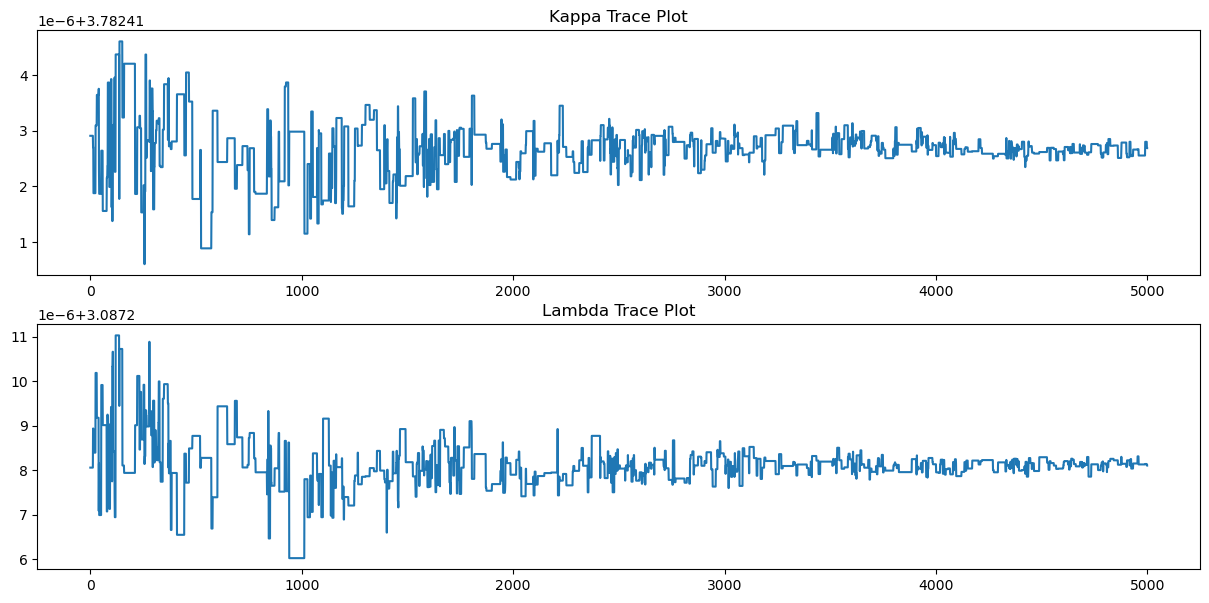

In [339]:
fig, ax = plt.subplots(2,1,figsize=(15,7))

ax[0].plot(kappa_store[15000:])
ax[1].plot(lambda_store[15000:])

ax[0].set_title('Kappa Trace Plot')
ax[1].set_title('Lambda Trace Plot')

## Mu Gamma Sigmas

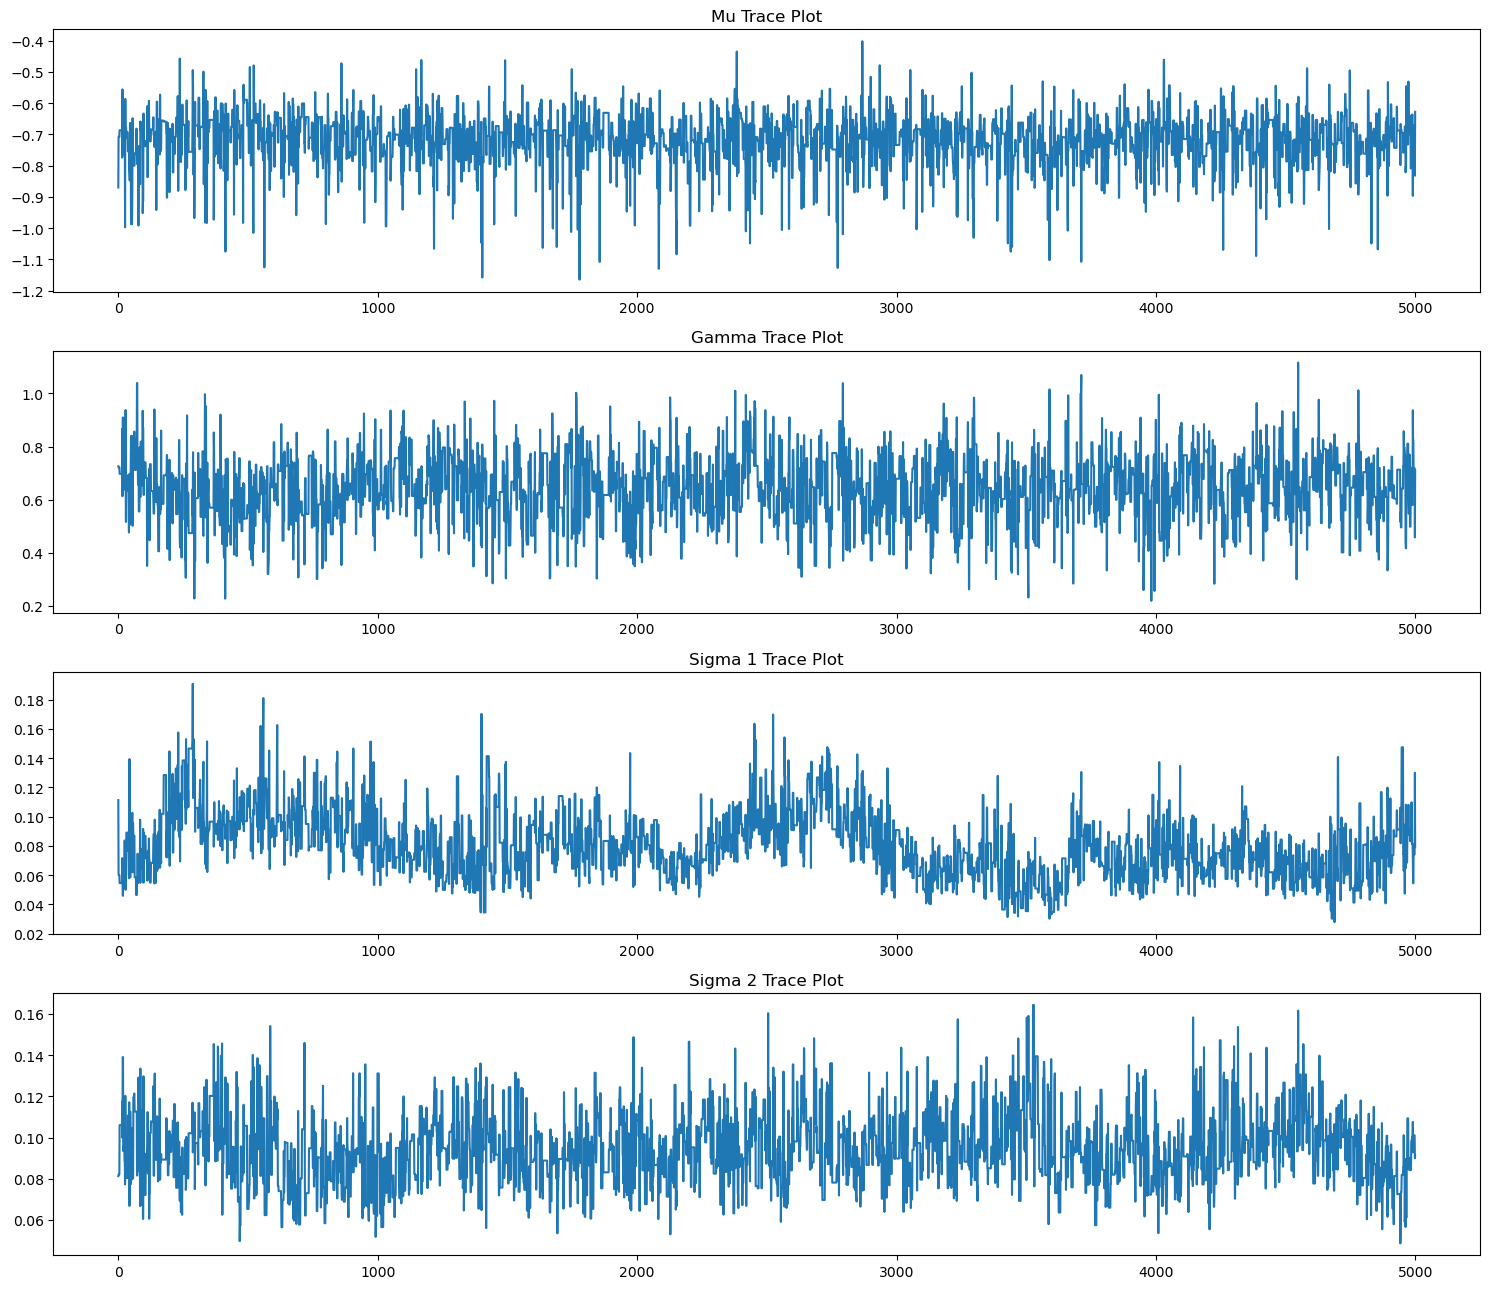

In [338]:
fig, ax = plt.subplots(4,1,figsize=(15,13))

ax[0].plot(mu_store[15000:])
ax[1].plot(gamma_store[15000:])
ax[2].plot(sigma_1_store[15000:])
ax[3].plot(sigma_2_store[15000:])

ax[0].set_title('Mu Trace Plot')
ax[1].set_title('Gamma Trace Plot')
ax[2].set_title('Sigma 1 Trace Plot')
ax[3].set_title('Sigma 2 Trace Plot')


plt.tight_layout()

## Inferred Beta 0 Beta 1 at various tau levels

In [18]:
from typing import List

In [19]:
def generate_beta_samples(tau_input: float,
                          tau_grid: np.ndarray,
                          w_approx_store: List[np.ndarray],
                          mu_store: List[float],
                          gamma_store: List[float],
                          sigma_1_store: List[float],
                          sigma_2_store: List[float]):

    beta_0_store = []
    beta_1_store = []

    for i in range(0,len(w_approx_store)):

        w_samp = w_approx_store[i]
        w1_samp = w_samp[0:100]
        w2_samp = w_samp[100:200]

        mu_samp = mu_store[i]
        gamma_samp = gamma_store[i]
        sigma_1_samp = sigma_1_store[i]
        sigma_2_samp = sigma_2_store[i]


        eta_1_samp = eta_function_i_vector(tau_input=np.array([tau_input]),
                                             w_vals=w1_samp,
                                             tau_grid=tau_grid,
                                             mean=0.0,
                                             sd=1.0,
                                             v=1,
                                             sigma=sigma_1_samp,
                                             dist='norm')[0]


        eta_2_samp = eta_function_i_vector(tau_input=np.array([tau_input]),
                                             w_vals=w2_samp,
                                             tau_grid=tau_grid,
                                             mean=0.0,
                                             sd=1.0,
                                             v=1,
                                             sigma=sigma_2_samp,
                                             dist='norm')[0]


        beta_0_samp = mu_samp + (eta_1_samp + eta_2_samp)/2
        beta_1_samp = gamma_samp + (eta_2_samp - eta_1_samp)/2

        beta_0_store.append(beta_0_samp)
        beta_1_store.append(beta_1_samp)
        
    return beta_0_store, beta_1_store

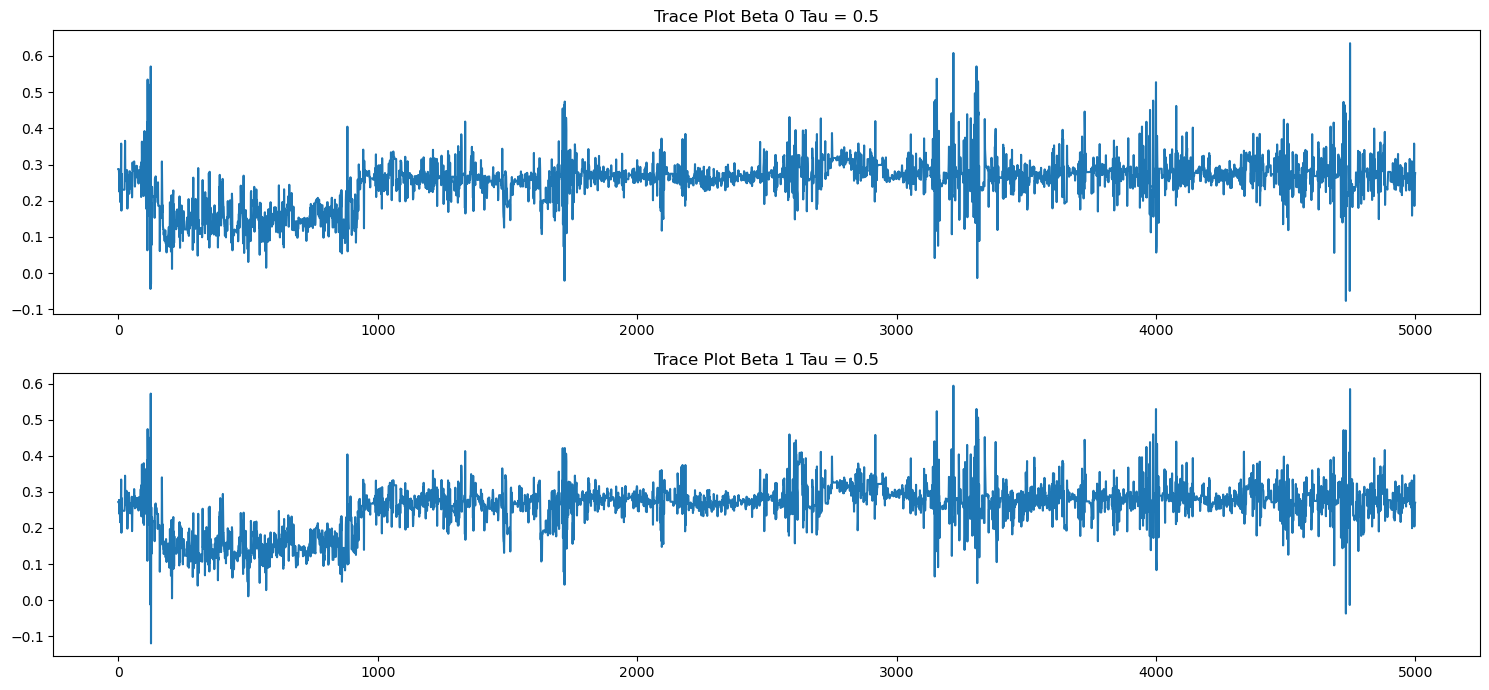

In [20]:
fig,ax = plt.subplots(2,1, figsize=(15,7))

input_tau = 0.5

beta_0_samps, beta_1_samps = generate_beta_samples(tau_input=input_tau,
                                                  tau_grid=tau_grid,
                                                  w_approx_store=w_approx_store,
                                                  mu_store=mu_store,
                                                  gamma_store=gamma_store,
                                                  sigma_1_store=sigma_1_store,
                                                  sigma_2_store=sigma_2_store)

ax[0].plot(beta_0_samps[15000:])
ax[1].plot(beta_1_samps[15000:])

ax[0].set_title('Trace Plot Beta 0 Tau = '+str(input_tau))
ax[1].set_title('Trace Plot Beta 1 Tau = '+str(input_tau))
plt.tight_layout()

Plot Example lines

In [21]:
y_pred_samples = np.array([b0 + b1*x_vals for b0,b1 in zip(beta_0_samps, beta_1_samps)])
y_pred_samples = y_pred_samples[15000:]

Text(0, 0.5, 'Y')

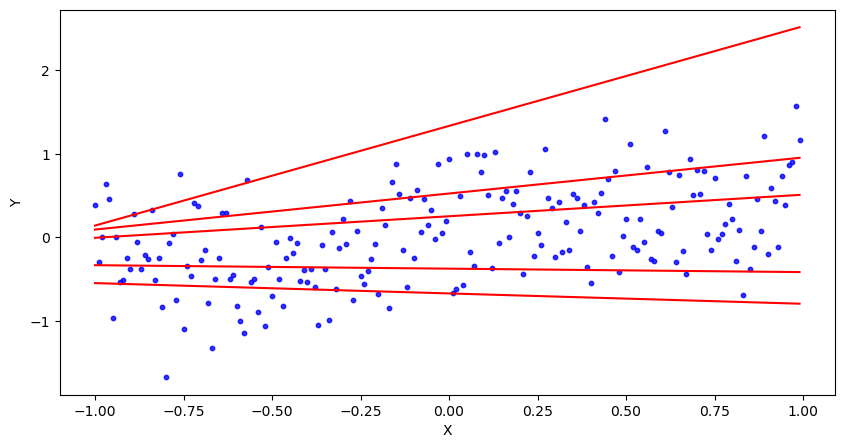

In [22]:
fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(x_vals, y_vals_true, s=10, color='blue', alpha=0.8)

#sample_quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
sample_quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]

for sq in sample_quantiles:
    
    beta_0_samps, beta_1_samps = generate_beta_samples(tau_input=sq,
                                                      tau_grid=tau_grid,
                                                      w_approx_store=w_approx_store,
                                                      mu_store=mu_store,
                                                      gamma_store=gamma_store,
                                                      sigma_1_store=sigma_1_store,
                                                      sigma_2_store=sigma_2_store)
    
    y_pred_samples = np.array([b0 + b1*x_vals for b0,b1 in zip(beta_0_samps, beta_1_samps)])
    y_pred_samples = y_pred_samples[15000:]
    ax.plot(x_vals, y_pred_samples.mean(0), color='red')


ax.set_xlabel('X')
ax.set_ylabel('Y')

In [141]:
lol_X = np.array([[1,0,0],
                  [1,0,0],
                  [1,0,0],
                  [0,1,0],
                  [0,1,0],
                  [0,1,0],
                  [0,0,1],
                  [0,0,1],
                  [0,0,1]] )

In [144]:
lol_X.T @ lol_X

array([[3, 0, 0],
       [0, 3, 0],
       [0, 0, 3]])

In [145]:
np.linalg.inv(lol_X.T @ lol_X)

array([[0.33333333, 0.        , 0.        ],
       [0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.33333333]])